<a href="https://colab.research.google.com/github/ishaan-arya/automated-essay-grading/blob/main/Automated_Essay_Grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 4.0 MB/s 


In [2]:
#importing the required libraries
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score, f1_score, cohen_kappa_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from spellchecker import SpellChecker

**Data Normalization**

In [3]:
from google.colab import files
uploaded = files.upload()

Saving training_set_rel3.csv to training_set_rel3.csv


In [4]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['training_set_rel3.csv']))

In [5]:
#selecting essay set 1-6 
df2 = df2[df2['essay_set'] < 7]
df2

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10679,16629,6,The one obstacle the builders had when trying ...,2,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10680,16630,6,Some of the problems with the constructing of ...,1,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10681,16631,6,The builders of the Empire State building face...,2,3,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10682,16632,6,The obstacles the builders of the Empire State...,2,1,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df2 = df2.dropna(axis=1)
df2 = df2.drop(['rater1_domain1', 'rater2_domain1'], axis = 1)
df2

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8
...,...,...,...,...
10679,16629,6,The one obstacle the builders had when trying ...,0
10680,16630,6,Some of the problems with the constructing of ...,2
10681,16631,6,The builders of the Empire State building face...,3
10682,16632,6,The obstacles the builders of the Empire State...,2


In [7]:
df2.describe()

,essay_id,essay_set,domain1_score
count,10684.000000,10684.000000,10684.000000
mean,8324.558499,3.506739,3.399757
std,5101.949452,1.713837,2.594460
min,1.000000,1.000000,0.000000
25%,3865.750000,2.000000,2.000000
50%,8895.500000,4.000000,3.000000
75%,12760.250000,5.000000,4.000000
max,16633.000000,6.000000,12.000000


In [8]:
df2.shape

(10684, 4)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


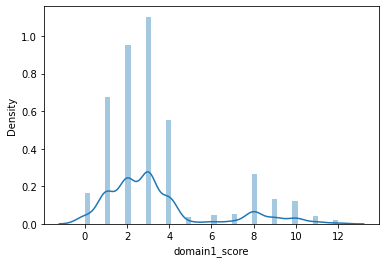

In [9]:
sns.distplot(df2['domain1_score'])

In [10]:
min_range = [2,1,0,0,0,0]
max_range = [12,6,3,3,4,4]

#using min-max normalisation
def normalize(x,mi,ma):
    x = (x-mi)/(ma-mi)
    return round(x*10)

df2['final_score']=df2.apply(lambda x:normalize(x['domain1_score'],min_range[x['essay_set']-1],max_range[x['essay_set']-1]),axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


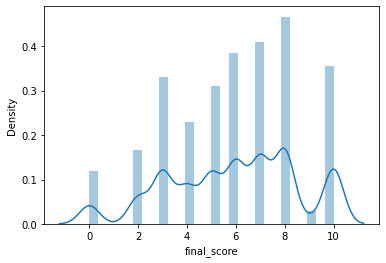

In [11]:
sns.distplot(df2['final_score'])

In [12]:
df2.drop('domain1_score',axis=1,inplace=True)
df2.head()

,essay_id,essay_set,essay,final_score
0,1,1,"Dear local newspaper, I think effects computer...",6
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",7
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",5
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",8
4,5,1,"Dear @LOCATION1, I know having computers has a...",6


In [ ]:
df2.describe()

,essay_id,essay_set,final_score
count,10684.000000,10684.000000,10684.000000
mean,8324.558499,3.506739,5.895170
std,5101.949452,1.713837,2.627745
min,1.000000,1.000000,0.000000
25%,3865.750000,2.000000,4.000000
50%,8895.500000,4.000000,6.000000
75%,12760.250000,5.000000,8.000000
max,16633.000000,6.000000,10.000000


**Data Cleaning**

In [13]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_essay(essay):
    x=[]
    for i in essay.split():
        if i.startswith("@"):
            continue
        else:
            x.append(i)
    return ' '.join(x)

df2['essay'] = df2['essay'].apply(lambda x:clean_essay(x))

stop_words = set(stopwords.words('english')) 

def remove_stop_words(essay):
    word_tokens = word_tokenize(essay) 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

df2['clean_essay'] = df2['essay'].apply(lambda x:remove_stop_words(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
def sent2word(x):
    x=re.sub("[^A-Za-z0-9]"," ",x)
    words=nltk.word_tokenize(x)
    return words

def essay2word(essay):
    essay = essay.strip()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw = tokenizer.tokenize(essay)
    final_words=[]
    for i in raw:
        if(len(i)>0):
            final_words.append(sent2word(i))
    return final_words
        

def noOfWords(essay):
    count=0
    for i in essay2word(essay):
        count=count+len(i)
    return count

def noOfChar(essay):
    count=0
    for i in essay2word(essay):
        for j in i:
            count=count+len(j)
    return count

def avg_word_len(essay):
    return noOfChar(essay)/noOfWords(essay)

def noOfSent(essay):
    return len(essay2word(essay))

def count_pos(essay):
    sentences = essay2word(essay)
    noun_count=0
    adj_count=0
    verb_count=0
    adverb_count=0
    for i in sentences:
        pos_sentence = nltk.pos_tag(i)
        for j in pos_sentence:
            pos_tag = j[1]
            if(pos_tag[0]=='N'):
                noun_count+=1
            elif(pos_tag[0]=='V'):
                verb_count+=1
            elif(pos_tag[0]=='J'):
                adj_count+=1
            elif(pos_tag[0]=='R'):
                adverb_count+=1
    return noun_count,verb_count,adj_count,adverb_count
    
def check_spell_errors(essay):
   essay = essay.lower()
   new_essay = re.sub("[^A-Za-z0-9]"," ",essay)
   new_essay = re.sub("[0-9]","",new_essay)
   count=0
   all_words = new_essay.split()
   spell = SpellChecker()
   misspelled = spell.unknown(all_words)
   return len(misspelled)



**Machine Learning**

In [15]:
#extracting features in the dataset

nltk.download('averaged_perceptron_tagger')

pro_data = df2.copy()
pro_data['char_count'] = pro_data['essay'].apply(noOfChar)
pro_data['word_count'] = pro_data['essay'].apply(noOfWords)
pro_data['sent_count'] = pro_data['essay'].apply(noOfSent)
pro_data['avg_word_len'] = pro_data['essay'].apply(avg_word_len)
pro_data['spell_err_count'] = pro_data['essay'].apply(check_spell_errors)
pro_data['noun_count'], pro_data['adj_count'], pro_data['verb_count'], pro_data['adv_count'] = zip(*pro_data['essay'].map(count_pos))
pro_data

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,essay_id,essay_set,essay,final_score,clean_essay,char_count,word_count,sent_count,avg_word_len,spell_err_count,noun_count,adj_count,verb_count,adv_count
0,1,1,"Dear local newspaper, I think effects computer...",6,"Dear local newspaper , I think effects compute...",1441,344,16,4.188953,5,76,75,18,24
1,2,1,Dear I believe that using computers will benef...,7,Dear I believe using computers benefit us many...,1765,413,17,4.273608,10,98,84,20,19
2,3,1,"Dear, More and more people use computers, but ...",5,"Dear , More people use computers , everyone ag...",1185,276,14,4.293478,2,76,51,20,16
3,4,1,"Dear Local Newspaper, I have found that many e...",8,"Dear Local Newspaper , I found many experts sa...",2284,490,26,4.661224,19,142,96,39,29
4,5,1,Dear I know having computers has a positive ef...,6,Dear I know computers positive effect people ....,2023,469,30,4.313433,8,110,90,32,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10679,16629,6,The one obstacle the builders had when trying ...,0,The one obstacle builders trying build buildin...,681,152,6,4.480263,5,40,29,7,15
10680,16630,6,Some of the problems with the constructing of ...,5,Some problems constructing docking dirigibles ...,319,66,3,4.833333,0,17,14,7,4
10681,16631,6,The builders of the Empire State building face...,8,The builders Empire State building faced obsta...,489,105,5,4.657143,0,31,18,8,6
10682,16632,6,The obstacles the builders of the Empire State...,5,The obstacles builders Empire State Building C...,305,68,2,4.485294,0,19,13,3,6


In [16]:
#vectorization and train-test split

vectorizer = CountVectorizer(max_features = 5000, ngram_range=(1, 3), stop_words='english')
count_vectors = vectorizer.fit_transform(pro_data['clean_essay'])
feature_names = vectorizer.get_feature_names()
X = count_vectors.toarray()
X_full = np.concatenate((pro_data.iloc[:, 5:].to_numpy(), X), axis = 1)
y_full = pro_data['final_score'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.2, random_state = 42)

In [ ]:
X_train.shape

(8547, 5009)

In [ ]:
X_test.shape

(2137, 5009)

In [17]:
#training the Multinomial Naive Bayes classifier model 

from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(X_train, y_train)
accuracy_score_mnb = metrics.accuracy_score(MNB.predict(X_test), y_test)

print('accuracy_score_mnb = '+str('{:04.2f}'.format(accuracy_score_mnb*100))+'%')

accuracy_score_mnb = 38.70%


In [19]:
#training the Multinomial Naive Bayes classifier model with the +/- range applied

from sklearn.naive_bayes import MultinomialNB
count = 0
total = 0
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
y_pred = MNB.predict(X_test)
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

55.545156761815626

In [ ]:
#training the Gaussian Naive Bayes classifier model 

from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
GNB.fit(X_train, y_train)
accuracy_score_gnb = metrics.accuracy_score(GNB.predict(X_test), y_test)

print('accuracy_score_gnb = '+str('{:04.2f}'.format(accuracy_score_gnb*100))+'%')

accuracy_score_gnb = 41.83%


In [ ]:
#training the Gaussian Naive Bayes classifier model with a +/- range applied

from sklearn.naive_bayes import GaussianNB
count = 0
total = 0
GNB = GaussianNB()
GNB.fit(X_train, y_train)
y_pred = GNB.predict(X_test)
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

56.29386991109031

In [ ]:
#training the Bernoulli Naive Bayes classifier model 

from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X_train, y_train)
accuracy_score_bnb = metrics.accuracy_score(BNB.predict(X_test), y_test)
print('accuracy_score_bnb = '+str('{:04.2f}'.format(accuracy_score_bnb*100))+'%')

accuracy_score_bnb = 46.33%


In [ ]:
#training the Bernoulli Naive Bayes classifier model with the +/- range applied

from sklearn.naive_bayes import BernoulliNB
count = 0
total = 0
BNB = BernoulliNB()
BNB.fit(X_train, y_train)
y_pred = BNB.predict(X_test)
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

62.43955701138668

In [ ]:
#training the logistic regression model

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='newton-cg', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score_logistic = metrics.accuracy_score(y_pred, y_test)
print('accuracy_score_logistic = '+str('{:04.2f}'.format(accuracy_score_logistic*100))+'%')

accuracy_score_logistic = 52.93%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [ ]:
#training the logistic regression model with the +/- range applied
count = 0
total = 0

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='newton-cg', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score_logistic = metrics.accuracy_score(y_pred, y_test)
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


81.93729527374825

In [ ]:
#training the logistic regression model with liblinear solver 

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score_logistic = metrics.accuracy_score(y_pred, y_test)
print('accuracy_score_logistic = '+str('{:04.2f}'.format(accuracy_score_logistic*100))+'%')

accuracy_score_logistic = 48.39%


In [ ]:
#training the logistic regression model with lbfgs solver 

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='sag', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score_logistic = metrics.accuracy_score(y_pred, y_test)
print('accuracy_score_logistic = '+str('{:04.2f}'.format(accuracy_score_logistic*100))+'%')

accuracy_score_logistic = 35.80%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
#training the K nearest neighbors classifie
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score_knn = metrics.accuracy_score(y_pred, y_test)
print('accuracy_score_knn = '+str('{:04.2f}'.format(accuracy_score_knn*100))+'%')

accuracy_score_knn = 50.40%


In [ ]:
#training the K nearest neighbors classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score_knn = metrics.accuracy_score(y_pred, y_test)
print('accuracy_score_knn = '+str('{:04.2f}'.format(accuracy_score_knn*100))+'%')

accuracy_score_knn = 50.40%


In [ ]:
#training the linear regression model

count = 0
total = 0
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test).round()
for i in y_test:
  if (y_test[i]==y_pred[i]):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

13.664014974262987

In [ ]:
#training the linear regression model with the +/- range applied

count = 0
total = 0
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test).round()
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

52.36312587739822

1 4.11302337528898
1 0.31545069576377405
11 2.2606189985226948
11 0.6237548340037875
21 2.1639458468168122
21 0.639844589081811
31 2.1340843574402406
31 0.644814573424473
41 2.1226296229767945
41 0.6467210373055863
51 2.1002126533462944
51 0.650451996155915
61 2.087532256183556
61 0.6525624526895062
71 2.0856083240554435
71 0.6528826615187605
81 2.082643266840732
81 0.6533761495610473
91 2.077575072723938
91 0.6542196723032787
101 2.0721885200444214
101 0.6551161809181212
111 2.0699775880890345
111 0.6554841564421279
121 2.0709830358099857
121 0.6553168151763431
131 2.0671820265834433
131 0.6559494345378225
141 2.0694399777184396
141 0.6555736333965629
151 2.065972437071815
151 0.6561507520561161
161 2.068116333418347
161 0.6557939335752898
171 2.067378538276982
171 0.6559167281973007
181 2.0633657213976093
181 0.6565845996758111
191 2.064203383540557
191 0.65644518373167
201 2.0630641691359135
201 0.6566347883988256
211 2.0620450294451933
211 0.6568044084818024
221 2.0611663131813276


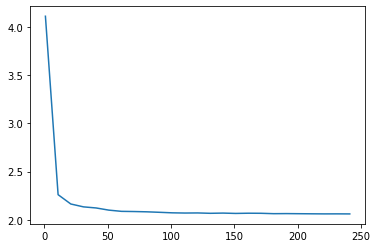

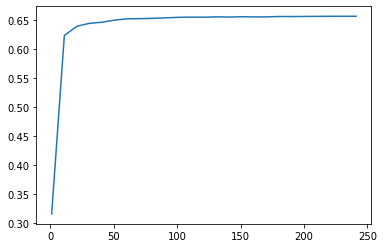

In [ ]:
#finding optimal n_estimators for the random forest model

import matplotlib.pyplot as plt

MSE = []
R2 = []
arr = []
i=1
count = 0
while i<250:
  rf = RandomForestRegressor(n_estimators = i, random_state = 42)
  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_test)
  MSE.append(mean_squared_error(y_test, y_pred))
  R2.append(r2_score(y_test, y_pred))
  arr.append(i)
  print(i,MSE[count])
  print(i,R2[count])
  count = count+1
  i=i+10
plt.plot(arr,MSE) 
plt.show()
plt.plot(arr,R2) 
plt.show()

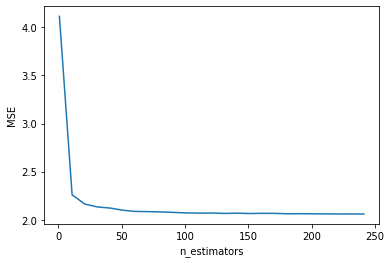

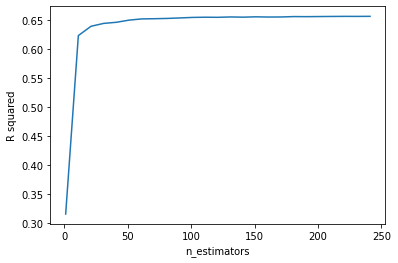

In [ ]:
plt.plot(arr,MSE)
plt.xlabel('n_estimators') 
plt.ylabel('MSE') 
plt.show()

plt.plot(arr,R2) 
plt.xlabel('n_estimators') 
plt.ylabel('R squared') 
plt.show()

In [ ]:
#training the random forest classifier model

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 150, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
accuracy_score_rfc = metrics.accuracy_score(y_pred, y_test)
print('accuracy_score_rfc = '+str('{:04.2f}'.format(accuracy_score_rfc*100))+'%')

accuracy_score_rfc = 63.78%


In [ ]:
#training the random forest model with the +/- range applied

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 150, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

85.91483387927

In [ ]:
#training the random forest regressor model

count = 0
total = 0
rf = RandomForestRegressor(n_estimators = 150, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test).round()
for i in y_test:
  if (y_test[i]==y_pred[i]):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

70.89377632194666

In [ ]:
#training the random forest regressor model with the +/- range applied

count = 0
total = 0
rf = RandomForestRegressor(n_estimators = 150, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test).round()
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

95.60131024801123

In [ ]:
count = 0
total = 0
rf = RandomForestRegressor(n_estimators = 150, random_state = 0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test).round()
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

95.60131024801123

In [ ]:
data = {'Predicted': y_pred, 'Actual': y_test}
df = pd.DataFrame(data)
df

,Predicted,Actual
0,6.0,3
1,6.0,6
2,6.0,6
3,6.0,6
4,3.0,4
...,...,...
2132,8.0,10
2133,6.0,5
2134,5.0,7
2135,7.0,8


In [ ]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("R^2 score: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 2.06
R^2 score: 0.66


In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score_clf = metrics.accuracy_score(y_pred, y_test)
print('accuracy_score_clf = '+str('{:04.2f}'.format(accuracy_score_clf*100))+'%')


accuracy_score_clf = 40.95%


In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score_clf = metrics.accuracy_score(y_pred, y_test)
print('accuracy_score_clf = '+str('{:04.2f}'.format(accuracy_score_clf*100))+'%')

for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

79.08282639213851

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score_clf = metrics.accuracy_score(y_pred, y_test)

for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

55.10060832943379

In [ ]:
#training the support vector regression model

clf = SVR(C=1.0, epsilon=0.2)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
for i in y_test:
  if (y_test[i]==y_pred[i]):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

52.72188426142568